In [1]:
import numpy as np
import scipy
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from scipy.integrate import odeint
from scipy.optimize import minimize
import pickle
from timeit import default_timer as timer
import sys, getopt
import time
import csv
import multiprocessing as mp
from multiprocessing import Pool
import os
import pandas as pd
import seaborn as sns
from scipy.optimize import Bounds
import pyreadr
import warnings
import copy
warnings.filterwarnings('ignore')
cmap = sns.diverging_palette(230, 20)
c=sns.color_palette("rocket")
colors_used = np.array([c[0],'#cc4c02',cmap[1],c[5]])

### Importing Needed Equations and Parameters

In [2]:
from coronavirusEqs import *
from fitting_params import *

### Get Initial Conditions

In [3]:
unvaxed = 1.0
vaxed = 0.0

frac_compart1 = np.array([0.9999, 0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0])#S,E,A,P,I,H,R,RA,RH
frac_compart_all = np.concatenate((unvaxed*frac_compart1,vaxed*frac_compart1,[0]))

In [4]:
numGroups = 10
totalFracRec = 0.0
currentInfections = .0000025*(total_pops) #~10 people infected total
frac_sym_old=(1-.321)*np.ones(10)
frac_sym_old[[0,5]]=(1-0.467)
frac_sym_old[[3,4,8,9]]=(1-0.197)

S0 = (1 - totalFracRec) * (total_pops - currentInfections)
I0 = frac_sym_old * currentInfections
E0 = np.zeros(numGroups)
A0 = (1 - frac_sym_old) * currentInfections
P0 = np.zeros(numGroups)
H0 = np.zeros(numGroups)
Rec0 = np.zeros(numGroups)
RecA0 = np.zeros(numGroups)
RecH0 = np.zeros(numGroups)
D = np.zeros(numGroups)
V0 = np.zeros(numGroups)
E_V0, A_V0, P_V0, I_V0, H_V0, RecV_0, RecAV_0, RecHV_0 = np.zeros(numGroups), \
                                                                                    np.zeros(numGroups), np.zeros(
            numGroups), np.zeros(numGroups), np.zeros(numGroups), np.zeros(numGroups), \
                                                                                    np.zeros(numGroups), np.zeros(
            numGroups)
Cases0 = np.copy(I0) + np.copy(A0)

In [5]:
y0 = np.array([S0, E0, A0, P0, I0, H0, Rec0, RecA0, RecH0,
                V0, E_V0, A_V0, P_V0, I_V0, H_V0, RecV_0, RecAV_0, RecHV_0,D,D,D]).reshape((21 * numGroups))

### Plotting function to visualize fit to mortality rate ratios

In [6]:
def plotting_fun_comp(deaths,total_pops,deaths_from_curr_inf,known_data):
    base_case = np.round(deaths-deaths_from_curr_inf)
    w_d=base_case[0:5]
    w_p =total_pops[0:5]
    w_m = w_d/w_p
    b_d=base_case[5:10]
    b_p =total_pops[5:10]
    b_m = b_d/b_p

    comp_plot = abs(b_m/w_m)
    c = 0
    for i in comp_plot:
        if np.isnan(i):
            comp_plot[c]=1
        if np.isinf(i):
            comp_plot[c]= abs(b_m[c]/(1/w_p[c]))
        c =c+1 
    # set width of bar
    barWidth = 0.3
    fig,ax = plt.subplots(figsize =(25, 15))

    # Set position of bar on X axis
    br1 = np.arange(5)
    br2 = [x + barWidth for x in br1]
    c=sns.color_palette("rocket") #0,1,5,4
    # Make the plot
    
    plt.bar(br1, np.round(comp_plot,1), color =colors_used[1], width = barWidth,
            edgecolor ='grey', label ='Model')

    label = np.round(comp_plot,1)
    bars2 = np.round(comp_plot,1)
    for i in range(len(br1)):
        plt.text(x = br1[i]-0.12 , y = bars2[i]+0.1, s = label[i], fontsize=30, color = 'k')

    plt.bar(br2, np.round(known_data,1), color =colors_used[3], width = barWidth,
            edgecolor ='grey', label ='Data')

    label =  np.round(known_data,1)
    bars1 =  np.round(known_data,1)
    for i in range(len(br2)):
        plt.text(x = br2[i]-0.12 , y = bars1[i]+0.1, s = label[i], fontsize=30, color = 'k')
    
    # Adding Xticks
    plt.title('COVID-19 Minority Mortality Rates Compared to White People', fontweight ='bold', fontsize = 30)
    plt.xticks([r + 0.5*barWidth for r in range(5)],
            ["Ages\n 0-19","Ages\n 20-49","Ages\n 50-59","Ages\n 60-69","Ages\n 70+"], fontsize = 30)
    ax.axes.yaxis.set_visible(False)
    plt.legend(loc='upper right', fontsize=30)
    plt.ylim([0,10])
    plt.show()
    return comp_plot

### Functions to run model with fit

In [7]:
def run_model_sd_all_year(params_test,y0):
    t = np.linspace(0,365,300)
    sol= scipy.integrate.solve_ivp(lambda t,y:coronavirusEqs_with_vaccination_only(t,y, params_test), [0,365],y0,t_eval=t)
    sol_plot=np.reshape(sol.y,(21,10,300))
    deaths =sol_plot[18,:,-1]
    
    y0_2021=sol_plot[:,:,-1].copy()
    y0_2021[18] = np.zeros(10)
    y0_2021[19] = np.zeros(10)
    y0_2021[20] = np.zeros(10)
    y0_2021=y0_2021.reshape(210)
    
    plt.plot(sol.t[10:],np.sum(sol_plot[1,:,10:],axis=0))
    plt.xlabel("Days")
    plt.ylabel("# Exposed")
    return [deaths,y0_2021]

def run_model_sd_delayed(params_test,c_new,y0):
    t = np.linspace(0,31,300)
    sol_int= scipy.integrate.solve_ivp(lambda t,y:coronavirusEqs_with_vaccination_only(t,y, params_test), [0,31],y0,t_eval=t)
    sol_plot=np.reshape(sol_int.y,(21,10,300))
    y0_2020=sol_plot[:,:,-1]
    y0_2020=y0_2020.reshape(210)

    contacts_total_new =c_new*params_test[1]
    params_test[1] = contacts_total_new

    t = np.linspace(0,365-31,300)
    sol= scipy.integrate.solve_ivp(lambda t,y:coronavirusEqs_with_vaccination_only(t,y, params_test), [0,365-31],y0_2020)
    sol_plot=np.reshape(sol.y,(21,10,len(sol.t)))
    deaths =sol_plot[18,:,-1]
    
    y0_2021=sol_plot[:,:,-1].copy()
    y0_2021[18] = np.zeros(10)
    y0_2021[19] = np.zeros(10)
    y0_2021[20] = np.zeros(10)
    y0_2021=y0_2021.reshape(210)
    
    plt.plot(sol.t[10:],np.sum(sol_plot[1,:,10:],axis=0))
    plt.xlabel("Days")
    plt.ylabel("# Exposed")
    return [deaths,y0_2021]

def next_four_mo_no_intervention(params_test,y0_2021):
    sol= scipy.integrate.solve_ivp(lambda t,y:coronavirusEqs_with_vaccination_only(t,y, params_test), [0,7*4*4],y0_2021)
    sol_plot=np.reshape(sol.y,(21,10,len(sol.t)))
    deaths =sol_plot[18,:,-1]
    return deaths

# Fit Contacts

In [8]:
# 2020 deaths per group in Oregon
known_deaths_o = np.array([0.,   17.,   49.,  173., 1130. , 1.,  33.,  55.,  76., 170.])
# 2020 mortality rate ratios per group in Oregon (in adults)
known_mr_comp =np.array([1,1,1,1,  5.70296553, 5.71635069, 4.03075636, 1.82451659])
all_mr_comp=np.array([1.8078089, 5.70296553, 5.71635069, 4.03075636, 1.82451659])

In [9]:
from fitting_functions import *

In [11]:
bounds = Bounds([0.1,0.3,0.4,0.6,0.6,0],[0.6,0.7,0.8,0.95,1,1])

s0 = np.array([0.5,0.7,0.7,0.7,0.8,0.3])
f = lambda sd: asymp_contact_multipliers_objfn_new(sd,fitting_params,known_mr_comp,known_deaths_o,y0,total_pops)
res1 = scipy.optimize.minimize(f,s0,method="trust-constr",bounds=bounds)
print(res1.x)

[0.44558108 0.48774912 0.73223004 0.73223004 0.85043308 0.40061321]


1704.0918663243538
[  3.  14.  94. 311. 799.]
[  5.  30. 117. 163. 168.]


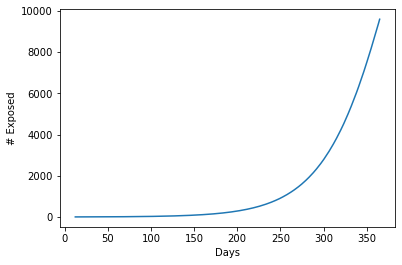

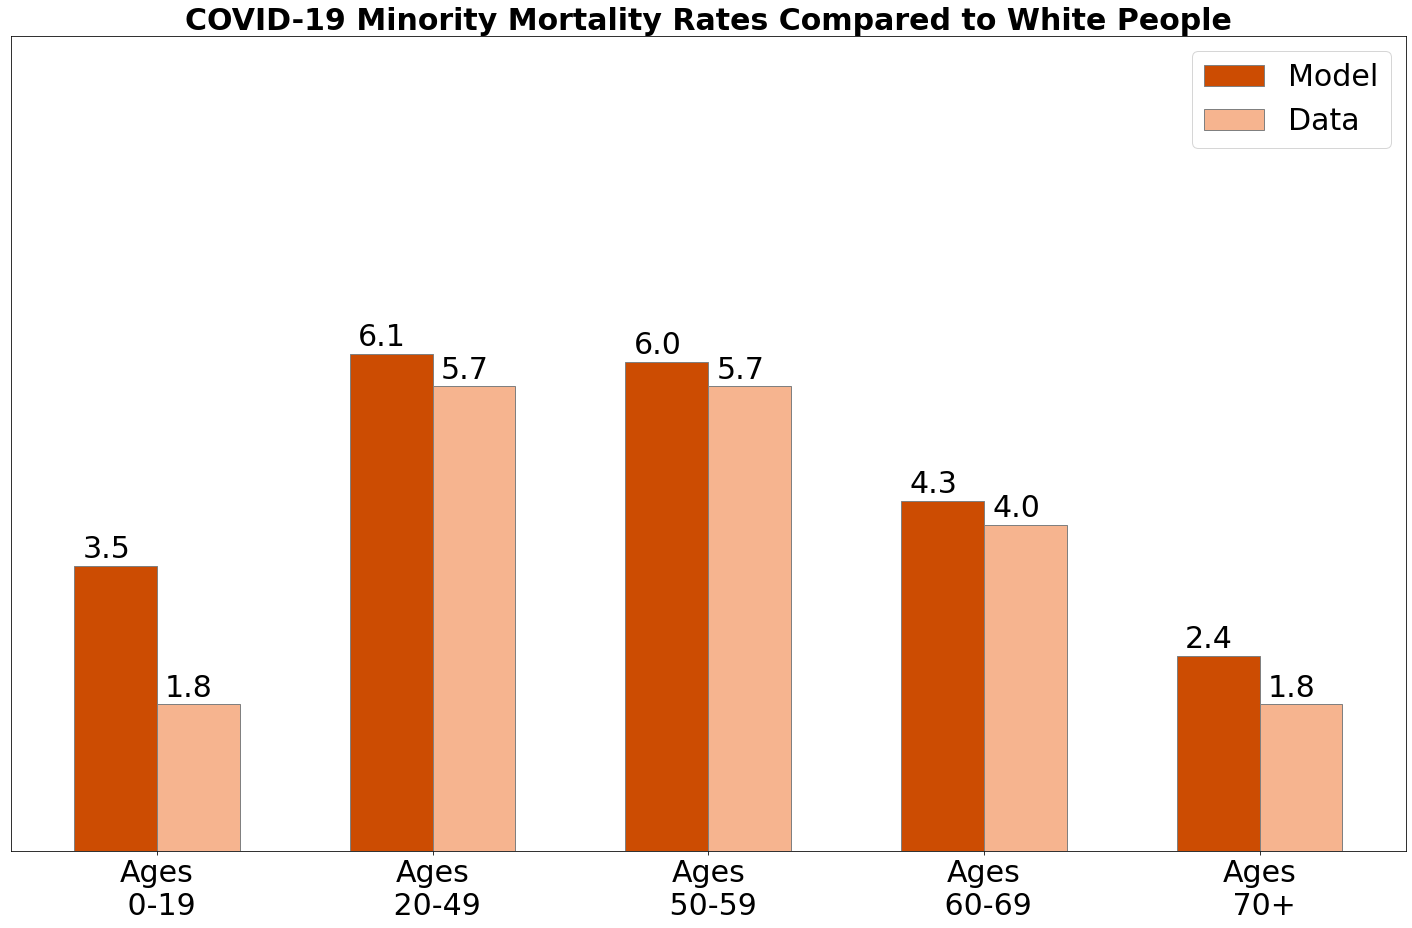

6996.775072144948


In [27]:
sol=res1.x
frac_sym_new = np.ones(10)
frac_sym_new[0:5]=sol[0:5]
frac_sym_new[5:]=sol[0:5]

#create new contact matrix
    
params_test = fitting_params.copy()
params_test[2]=frac_sym_new
params_test[11]=np.ones(10) - frac_sym_new
beta_new = findBetaModel_coronavirusEqs(C, frac_sym_new, gammaA, gammaE,  gammaI, gammaP, hosp_rate, redA,  redP, red_sus, sigma, R0, totalPop)
params_test[0]=beta_new
contacts_total_new =sol[5]*C
params_test[1] = contacts_total_new


#run model
[deaths, y0_2021] = run_model_sd_all_year(params_test,y0)
print(sum(deaths))
print(np.round(deaths[0:5]))
print(np.round(deaths[5:10]))
plotting_fun_comp(deaths,total_pops,np.zeros(10),all_mr_comp)


deaths_new = next_four_mo_no_intervention(params_test,y0_2021)
print(sum(deaths_new))

In [30]:
bounds = Bounds([0.1,0.3,0.4,0.6,0.6,0],[0.6,0.7,0.8,0.95,1,1])
s0 = np.array([0.5,0.7,0.7,0.7,0.8,0.3])
f = lambda sd: asymp_contact_multipliers_objfn_social_distancing_later(sd,fitting_params,known_mr_comp,known_deaths_o,y0,total_pops)
res2 = scipy.optimize.minimize(f,s0,method="trust-constr",bounds=bounds)
print(res2.x)

[0.19725209 0.4004314  0.4004314  0.60068164 0.99978947 0.34610121]


1704.0873464098759
[  1.  11.  50. 253. 968.]
[  2.  24.  62. 132. 202.]


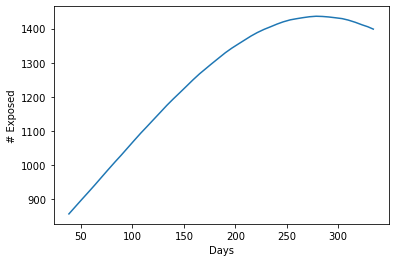

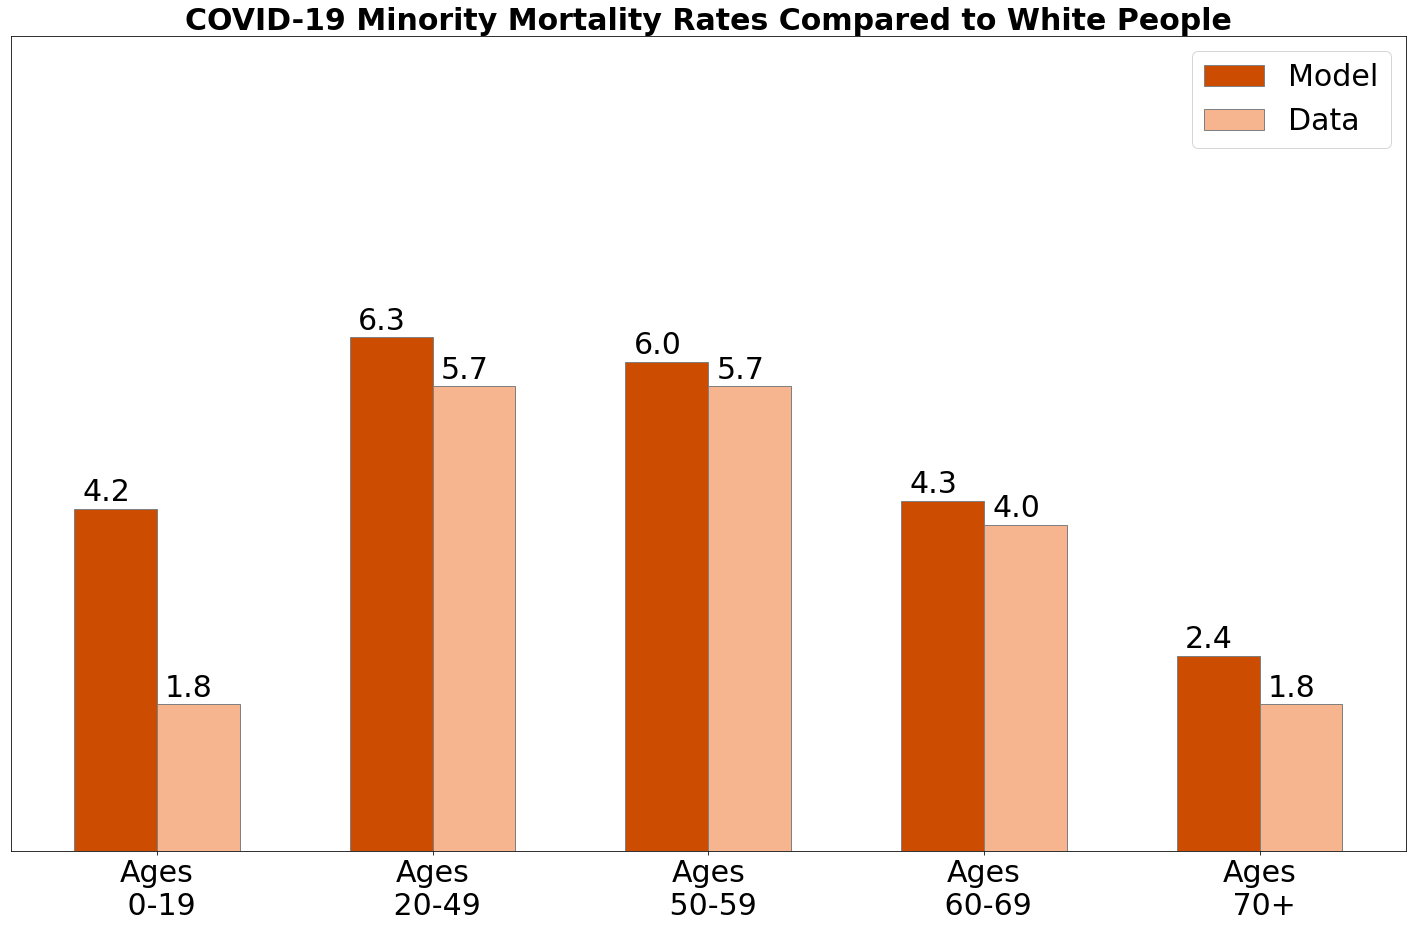

636.8746552258157


In [34]:
sol=res2.x
frac_sym_new = np.ones(10)
frac_sym_new[0:5]=sol[0:5]
frac_sym_new[5:]=sol[0:5]

#create new contact matrix
    
params_test = fitting_params.copy()
params_test[2]=frac_sym_new
params_test[11]=np.ones(10) - frac_sym_new
beta_new = findBetaModel_coronavirusEqs(C, frac_sym_new, gammaA, gammaE,  gammaI, gammaP, hosp_rate, redA,  redP, red_sus, sigma, R0, totalPop)
params_test[0]=beta_new

[deaths, y0_2021] = run_model_sd_delayed(params_test,sol[5],y0)
params_test[1]=sol[5]*C
print(sum(deaths))
print(np.round(deaths[0:5]))
print(np.round(deaths[5:10]))
plotting_fun_comp(deaths,total_pops,np.zeros(10),all_mr_comp)


deaths_new = next_four_mo_no_intervention(params_test,y0_2021)
print(sum(deaths_new))

In [36]:
bounds = Bounds([0.1,0.3,0.4,0.6,0.6,0,0,0.7,0],[0.6,0.7,0.7,0.9,1,1,1,1,0.2])
s0 = np.array([0.5,0.7,0.7,0.7,0.8,0.1,0.1,0.7,0.01])
f = lambda sd: asymp_contact_multipliers_and_4_mat(sd,fitting_params,known_mr_comp,known_deaths_o,y0,total_pops)
res3 = scipy.optimize.minimize(f,s0,method='trust-constr',bounds=bounds)
print(res3.x)

[0.47820245 0.69627949 0.4476953  0.60164803 0.99849182 0.0646952
 0.44616019 0.74290909 0.06344849]


1962.7184842254985
[1.00e+00 1.50e+01 5.00e+01 2.68e+02 1.13e+03]
[  2.  34.  65. 148. 250.]


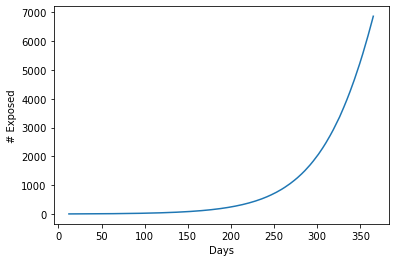

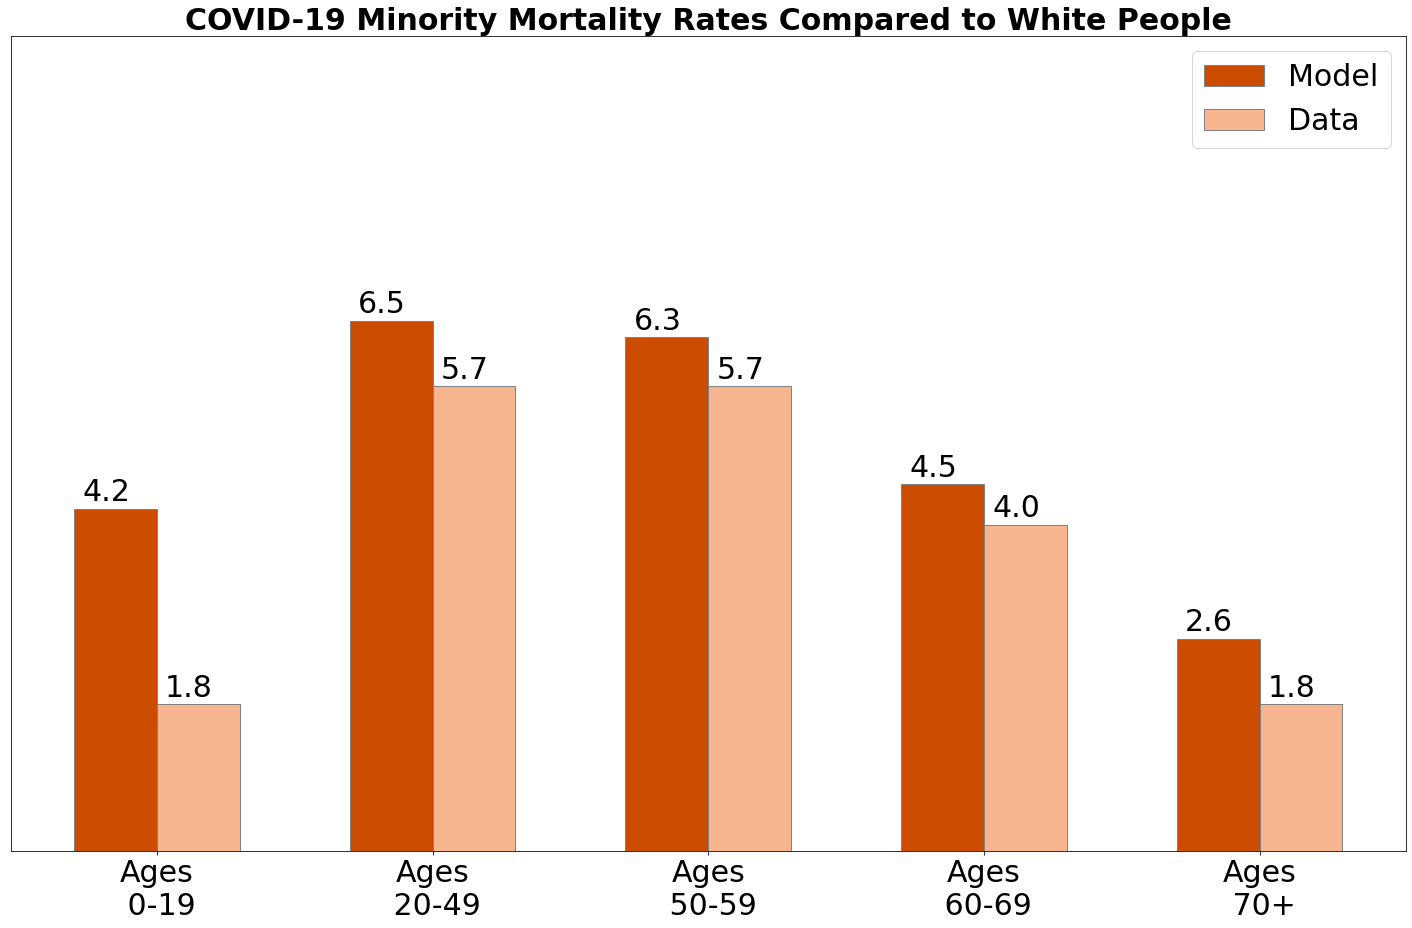

8915.298083924512


In [37]:
sol=res3.x
frac_sym_new = np.ones(10)
frac_sym_new[0:5]=sol[0:5]
frac_sym_new[5:]=sol[0:5]

#create new contact matrix
contacts_total_new = sol[5]*work_total+sol[6]*other_total+sol[7]*home_total +sol[8]*school_total 
    
params_test = fitting_params.copy()
params_test[2]=frac_sym_new
beta_new = findBetaModel_coronavirusEqs(C, frac_sym_new, gammaA, gammaE,  gammaI, gammaP, hosp_rate, redA,  redP, red_sus, sigma, R0, totalPop)
params_test[0]=beta_new
params_test[1] = contacts_total_new
params_test[11]=np.ones(10) - frac_sym_new

#run model
[deaths, y0_2021] = run_model_sd_all_year(params_test,y0)
print(sum(deaths))
print(np.round(deaths[0:5]))
print(np.round(deaths[5:10]))
plotting_fun_comp(deaths,total_pops,np.zeros(10),all_mr_comp)


deaths_new = next_four_mo_no_intervention(params_test,y0_2021)
print(sum(deaths_new))

## Old fits

In [10]:
bounds = Bounds([0],[1])
s0 = 0.33*np.ones(1)
f = lambda sd: single_contacts_multiplier_objfn(sd,fitting_params,known_mr_comp,known_deaths_o,y0,total_pops)
res4 = scipy.optimize.minimize(f,s0,method='nelder-mead',bounds=bounds)
print(res4.x)


[0.40011325]


In [29]:
def contact_multipliers_objfn_total_d_1(sd_params,params,known_mr_comp,y0,pops):
    #create new contact matrix
    contacts_total_new = sd_params[0]*contacts_total
    params[1] = contacts_total_new
    #run model
    t = np.linspace(0,365,300)
    sol= scipy.integrate.solve_ivp(lambda t,y:coronavirusEqs_with_vaccination_only(t,y, params),[0,365],y0,t_eval=t)
    sol_plot=np.reshape(sol.y,(21,10,300))
    deaths =sol_plot[18,:,-1]
    mr = deaths/pops
    #compare to known deaths
    dw = mr[1:5]
    db = mr[6:10]
    dr = np.array([dw,db])/dw
    dr = dr.reshape(8)
    d = sum(abs(dr - known_mr_comp))**4 + sum(abs(deaths-known_deaths_o))+abs(sum(deaths)-sum(known_deaths_o))
    return d

In [31]:
contact_multipliers_objfn_total_d_1([0.40011325],fitting_params,known_mr_comp,y0,total_pops)

783.4585268566108

In [28]:
single_contacts_multiplier_objfn([0.34096333],fitting_params,known_mr_comp,known_deaths_o,y0,total_pops)

3403.000404015943

1703.99972202151
[  3.  20.  88. 343. 754.]
[  6.  43. 110. 180. 158.]


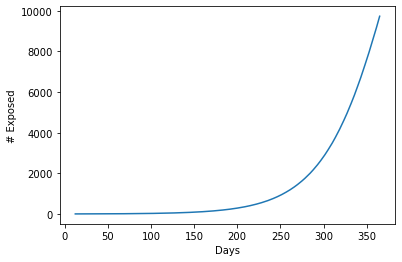

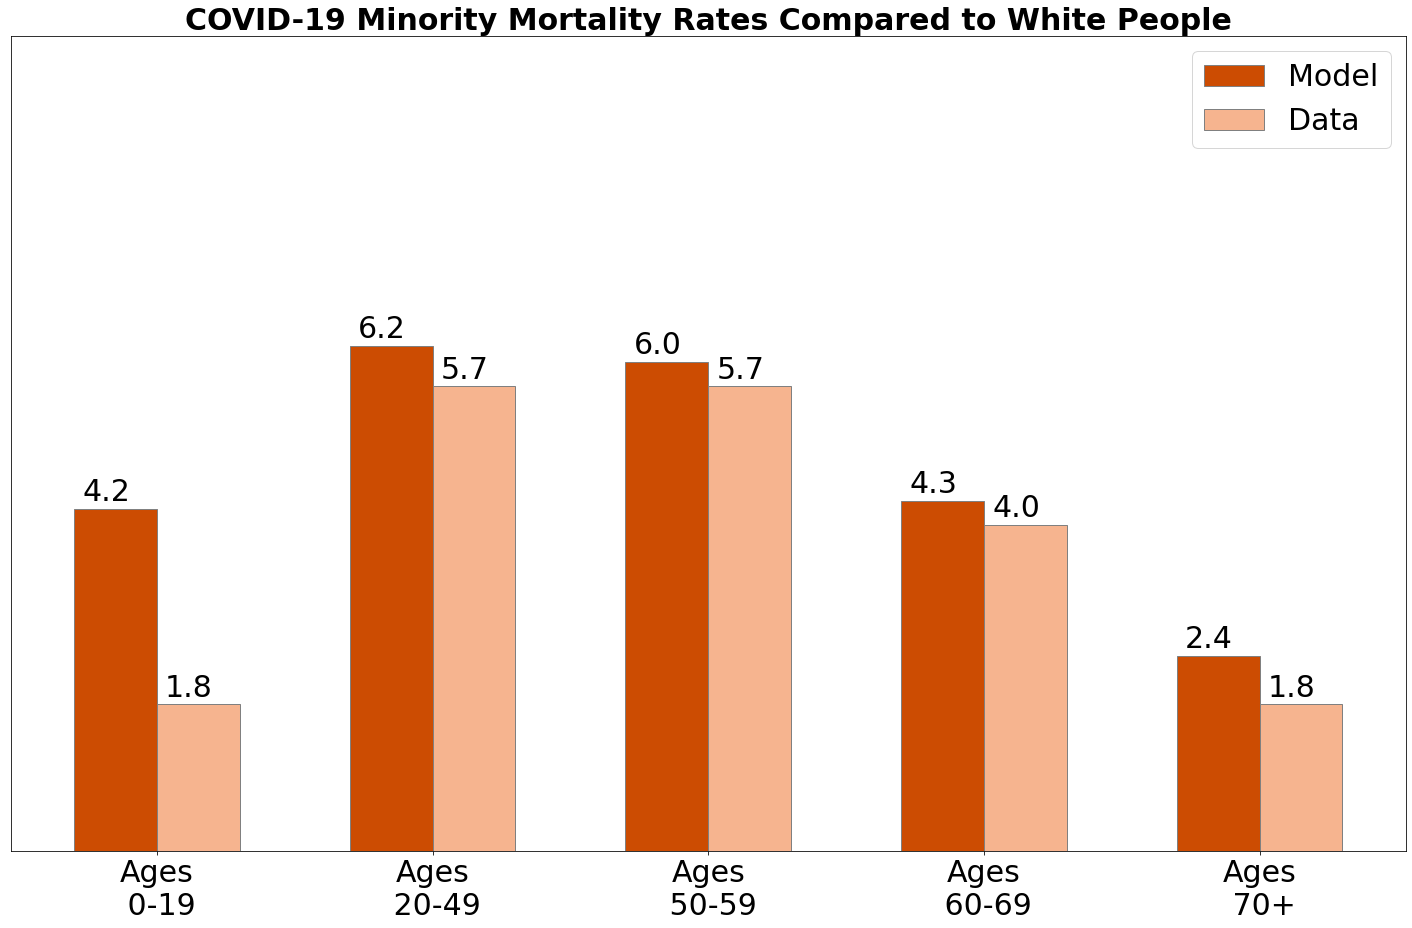

6915.63665524663


In [11]:
sol = res4.x

params_test = fitting_params.copy()
contacts_total_new = sol*C
params_test[1] = contacts_total_new

#run model
[deaths, y0_2021] = run_model_sd_all_year(params_test,y0)
print(sum(deaths))
print(np.round(deaths[0:5]))
print(np.round(deaths[5:10]))
plotting_fun_comp(deaths,total_pops,np.zeros(10),all_mr_comp)


deaths_new = next_four_mo_no_intervention(params_test,y0_2021)
print(sum(deaths_new))

In [13]:
bounds = Bounds([0.1,0.1,0,0,0.5,0.5,0,0],[1,1,1,1,1,1,0.2,0.2])
s0 =np.array([.1,.1,.2,.2,.6,.6,0.1,0.1])
f = lambda sd: contact_multipliers_4mat_2race(sd,fitting_params,known_mr_comp,known_deaths_o,y0,total_pops)
res5 = scipy.optimize.minimize(f,s0,method='nelder-mead',bounds=bounds)
print(res5.x)

[0.14330149 0.1        0.28481106 0.15690188 0.94155099 1.
 0.13795373 0.06402145]


1704.0000383867075
[  1.  13.  72. 343. 831.]
[  2.  24.  83. 170. 166.]


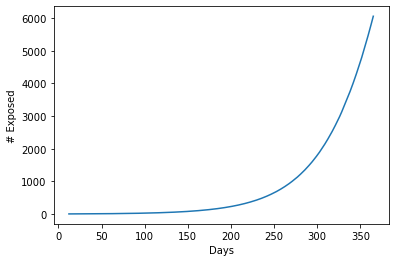

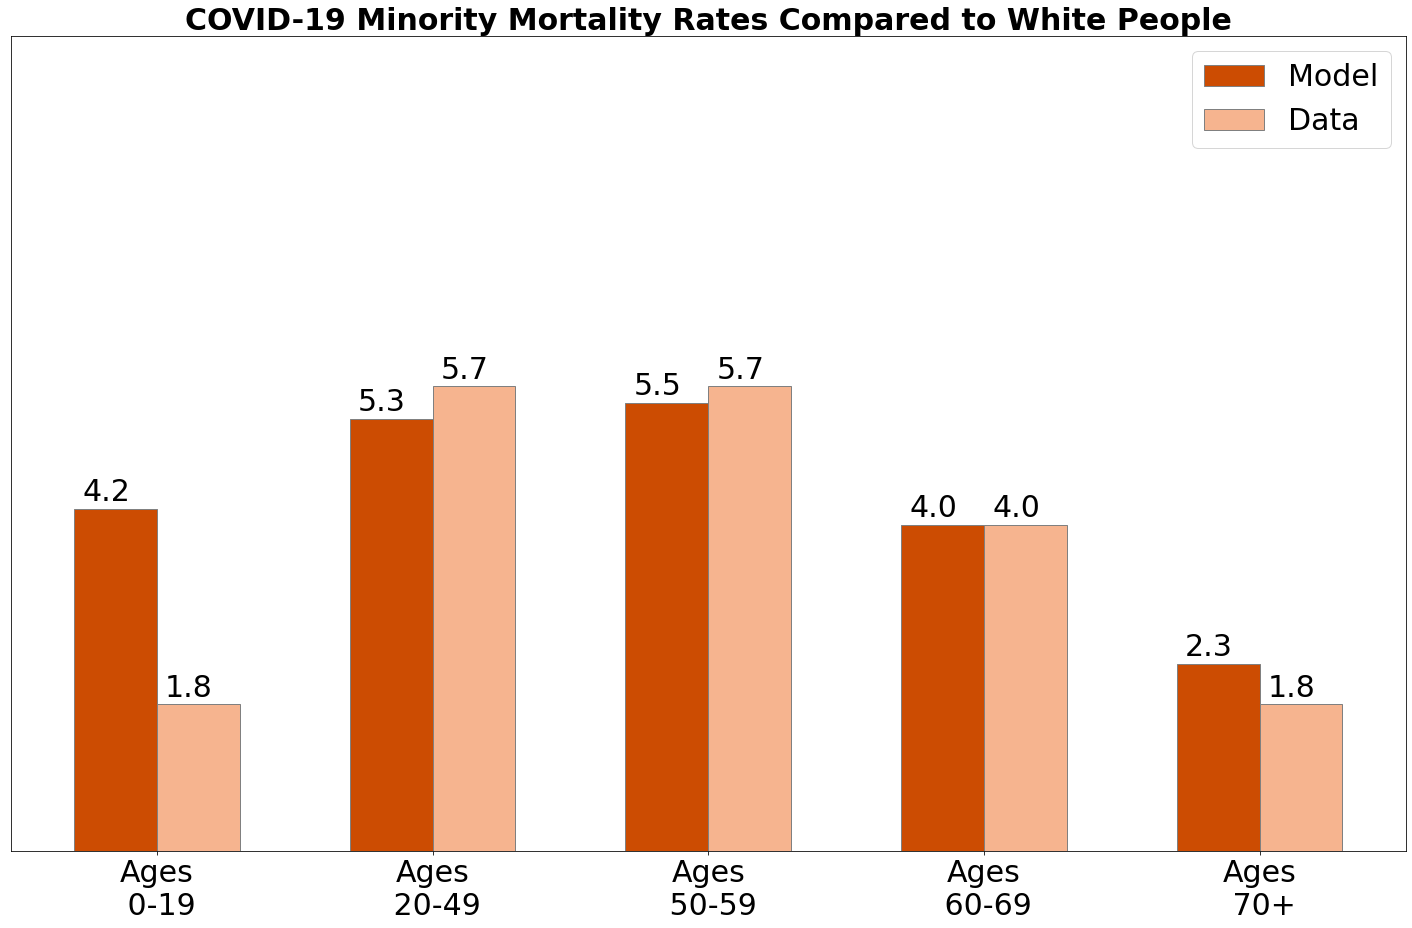

8086.608739077941


In [14]:
sd_params = res5.x
work_total_new = np.vstack((sd_params[0]*w_work,sd_params[1]*other_work))
other_total_new = np.vstack((sd_params[2]*w_other,sd_params[3]*other_other))
home_total_new = np.vstack((sd_params[4]*w_home,sd_params[5]*other_home))
school_total_new = np.vstack((sd_params[6]*w_school,sd_params[7]*other_school))
    
contacts_total_new = work_total_new+other_total_new+home_total_new+school_total_new
params_test = fitting_params.copy()
params_test[1] = contacts_total_new

#run model
[deaths, y0_2021] = run_model_sd_all_year(params_test,y0)
print(sum(deaths))
print(np.round(deaths[0:5]))
print(np.round(deaths[5:10]))
plotting_fun_comp(deaths,total_pops,np.zeros(10),all_mr_comp)


deaths_new = next_four_mo_no_intervention(params_test,y0_2021)
print(sum(deaths_new))

In [15]:
bounds = Bounds([0.1,0.1,0,0,0.5,0.5,0,],[1,1,1,1,1,1,.2])
s0 = np.array([0.1,0.1,0.3,0.3,0.7,0.7,0.1])
f = lambda sd: contact_multipliers_all_school_same(sd,fitting_params,known_mr_comp,known_deaths_o,y0,total_pops)
res6 = scipy.optimize.minimize(f,s0,method='nelder-mead',bounds=bounds)
print(res6.x)

[0.10000926 0.10010445 0.37826536 0.23890312 0.81425371 0.85343791
 0.12683708]


1703.999923644777
[  1.  14.  73. 343. 835.]
[  2.  26.  83. 166. 161.]


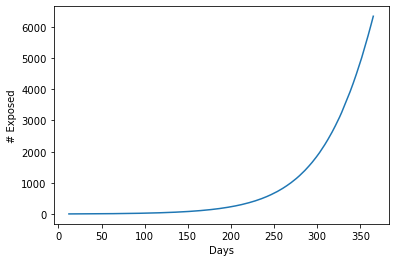

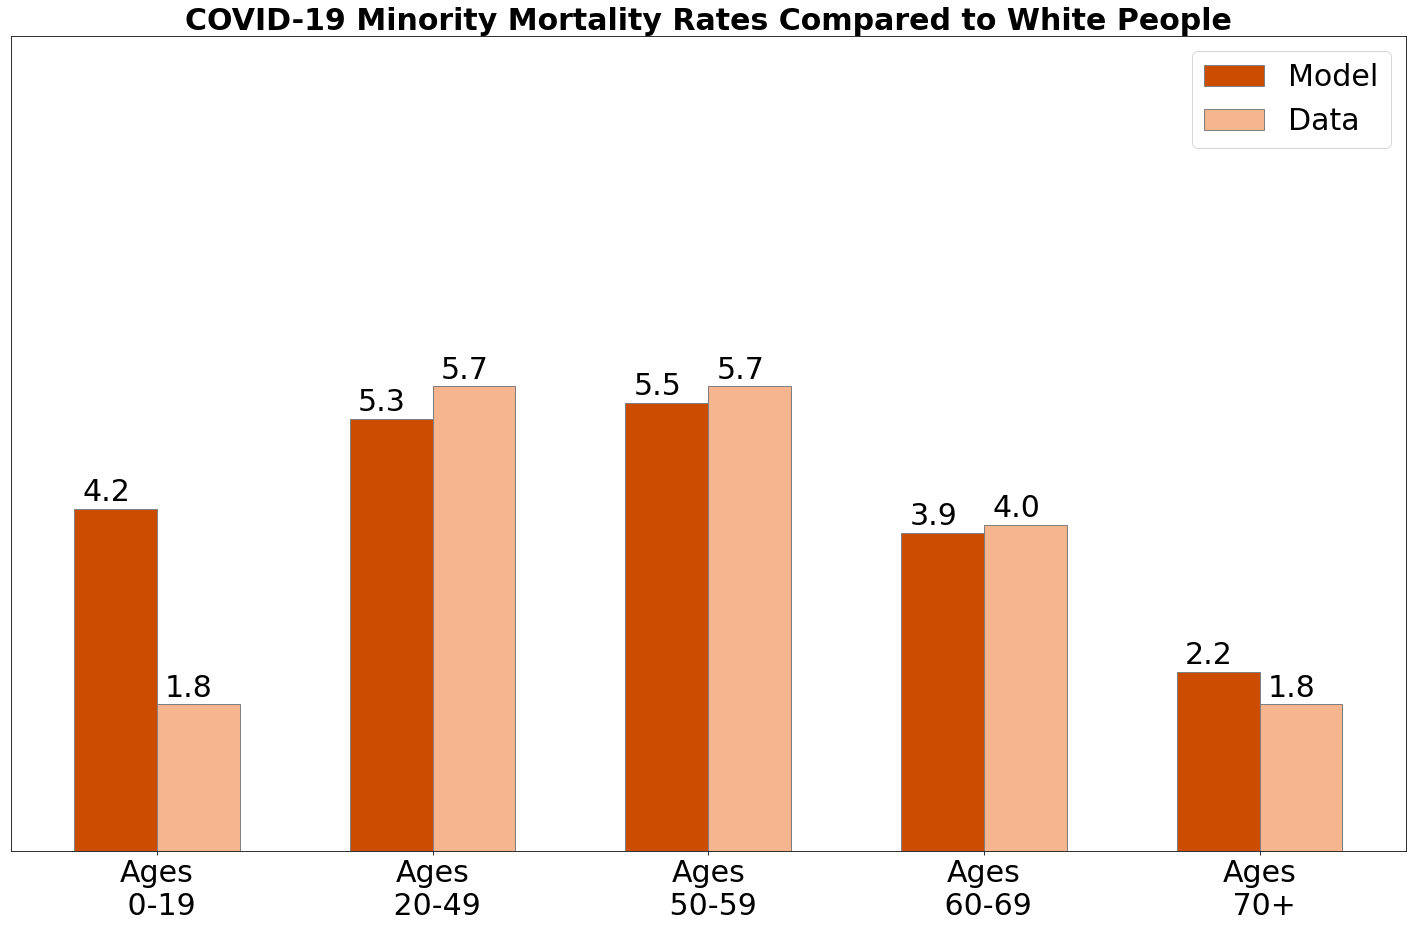

8100.370679676298


In [16]:
sd_params = res6.x
work_total_new = np.vstack((sd_params[0]*w_work,sd_params[1]*other_work))
other_total_new = np.vstack((sd_params[2]*w_other,sd_params[3]*other_other))
home_total_new = np.vstack((sd_params[4]*w_home,sd_params[5]*other_home))
school_total_new = np.vstack((sd_params[6]*w_school,sd_params[6]*other_school))
    
contacts_total_new = work_total_new+other_total_new+home_total_new+school_total_new
params_test = fitting_params.copy()
params_test[1] = contacts_total_new

#run model
[deaths, y0_2021] = run_model_sd_all_year(params_test,y0)
print(sum(deaths))
print(np.round(deaths[0:5]))
print(np.round(deaths[5:10]))
plotting_fun_comp(deaths,total_pops,np.zeros(10),all_mr_comp)


deaths_new = next_four_mo_no_intervention(params_test,y0_2021)
print(sum(deaths_new))

In [36]:
bounds = Bounds([0.0,0,0.0,0],[1,1,1,0.2])
s0 = np.array([0.1,0.2,0.7,0.1])
f = lambda sd: contact_multipliers_4mat(sd,fitting_params,known_mr_comp,known_deaths_o,y0,total_pops)
res7 = scipy.optimize.minimize(f,s0,method='nelder-mead',bounds=bounds)
print(res7.x)

[0.2222703  0.71280492 0.32005584 0.12805218]


1703.9999954104642
[  2.  18.  81. 338. 809.]
[  3.  37.  95. 164. 157.]


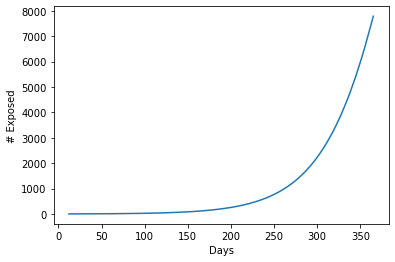

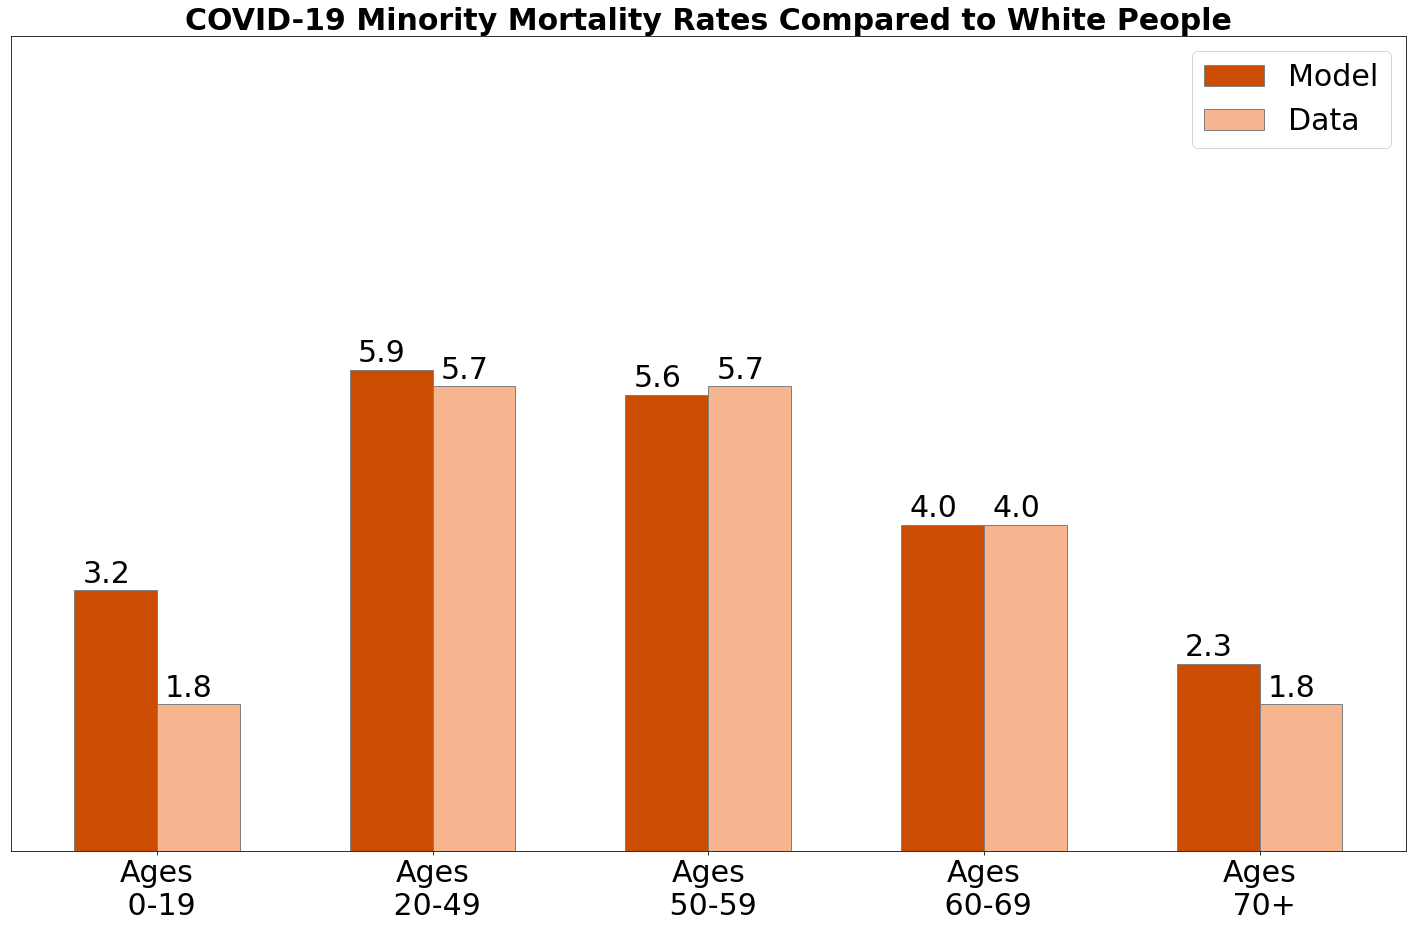

7990.706814443711


In [38]:
sd_params=res7.x
contacts_total_new = sd_params[0]*work_total+sd_params[1]*other_total+sd_params[2]*home_total+sd_params[3]*school_total
params_test = fitting_params.copy()
params_test[1] = contacts_total_new

#run model
[deaths, y0_2021] = run_model_sd_all_year(params_test,y0)
print(sum(deaths))
print(np.round(deaths[0:5]))
print(np.round(deaths[5:10]))
plotting_fun_comp(deaths,total_pops,np.zeros(10),all_mr_comp)


deaths_new = next_four_mo_no_intervention(params_test,y0_2021)
print(sum(deaths_new))

In [39]:
bounds = Bounds([0.1,0,0,0.5,0.5,0],[1,1,1,1,1,.2])
s0 = np.array([0.1,0.3,0.3,0.7,0.7,0.1])
f = lambda sd: contact_multipliers_all_school_and_work_same(sd,fitting_params,known_mr_comp, known_deaths_o,y0,total_pops)
res8 = scipy.optimize.minimize(f,s0,method='nelder-mead',bounds=bounds)
print(res8.x)


[0.10221579 0.28506023 0.45046306 0.95394628 0.57618642 0.13205359]


1704.0006563587378
[  1.  13.  74. 356. 861.]
[  2.  27.  77. 147. 145.]


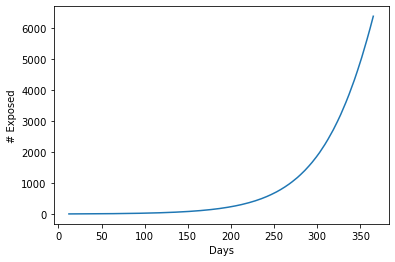

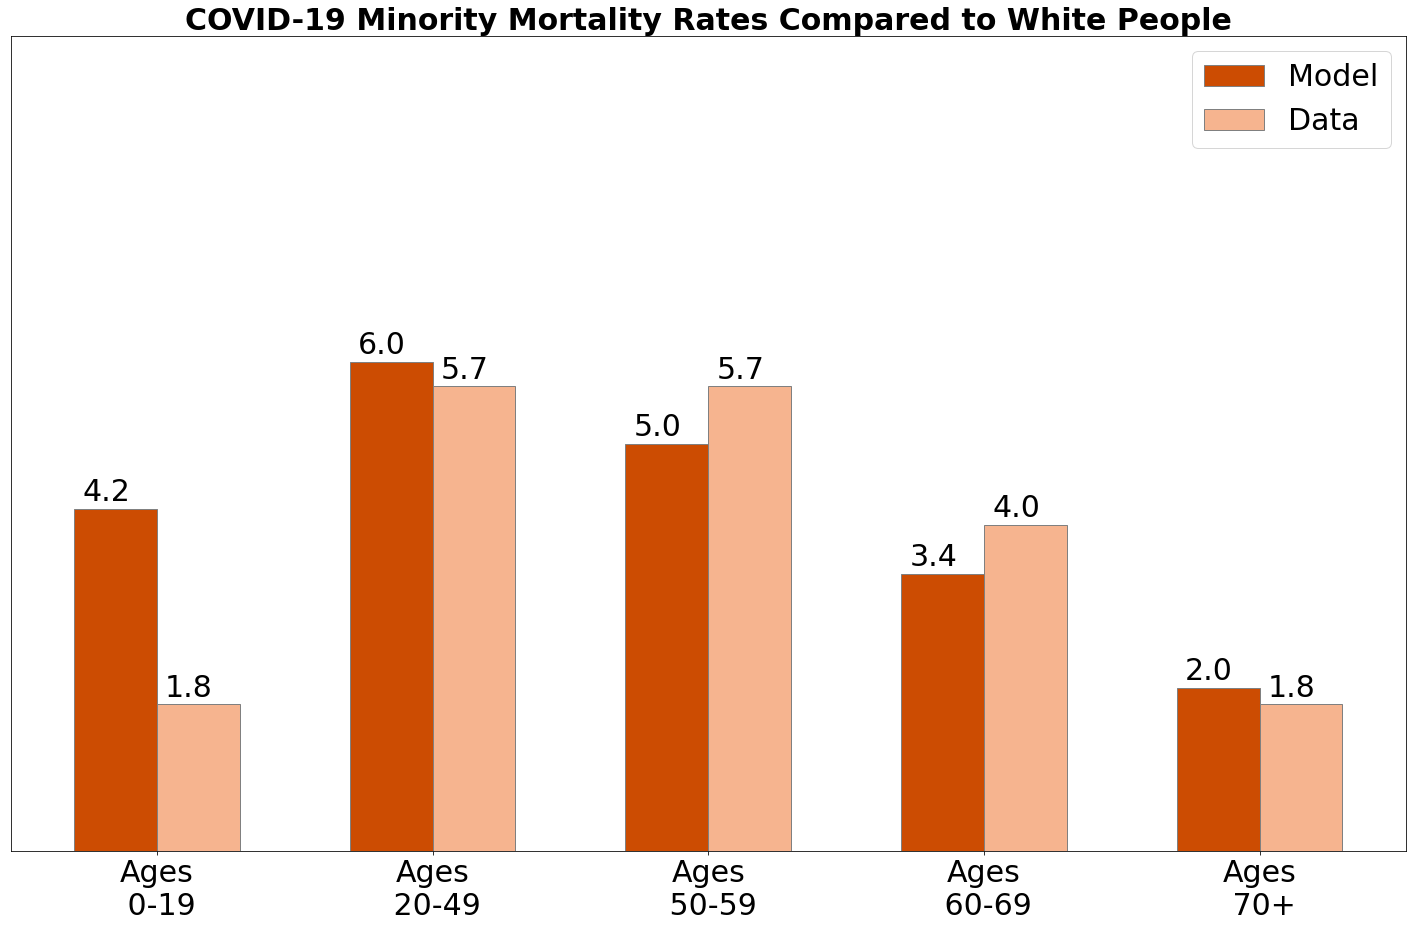

8111.209277554095


In [40]:
sd_params=res8.x
contacts_total_new = sd_params[0]*work_total+np.vstack((sd_params[1]*w_other,sd_params[2]*other_other))+np.vstack((sd_params[3]*w_home,sd_params[4]*other_home)) +sd_params[5]*school_total 
params_test = fitting_params.copy()
params_test[1] = contacts_total_new

#run model
[deaths, y0_2021] = run_model_sd_all_year(params_test,y0)
print(sum(deaths))
print(np.round(deaths[0:5]))
print(np.round(deaths[5:10]))
plotting_fun_comp(deaths,total_pops,np.zeros(10),all_mr_comp)


deaths_new = next_four_mo_no_intervention(params_test,y0_2021)
print(sum(deaths_new))

In [12]:
bounds = Bounds([0,0,0,0,0],[1,1,1,1,1])
s0 = 0.2*np.ones(5)
f = lambda sd: contact_multipliers_objfn_fit_age(sd,fitting_params,known_mr_comp,known_deaths_o,y0,total_pops)
res9 = scipy.optimize.minimize(f,s0,method='nelder-mead',bounds=bounds)
print(res9.x)

[4.19128485e-01 1.41213367e-01 2.78157522e-05 9.76077886e-01
 5.21244885e-01]


2292.3077814183803
[   3.   17.   79.  460. 1128.]
[  6.  36.  95. 239. 231.]


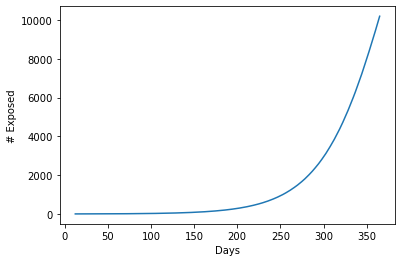

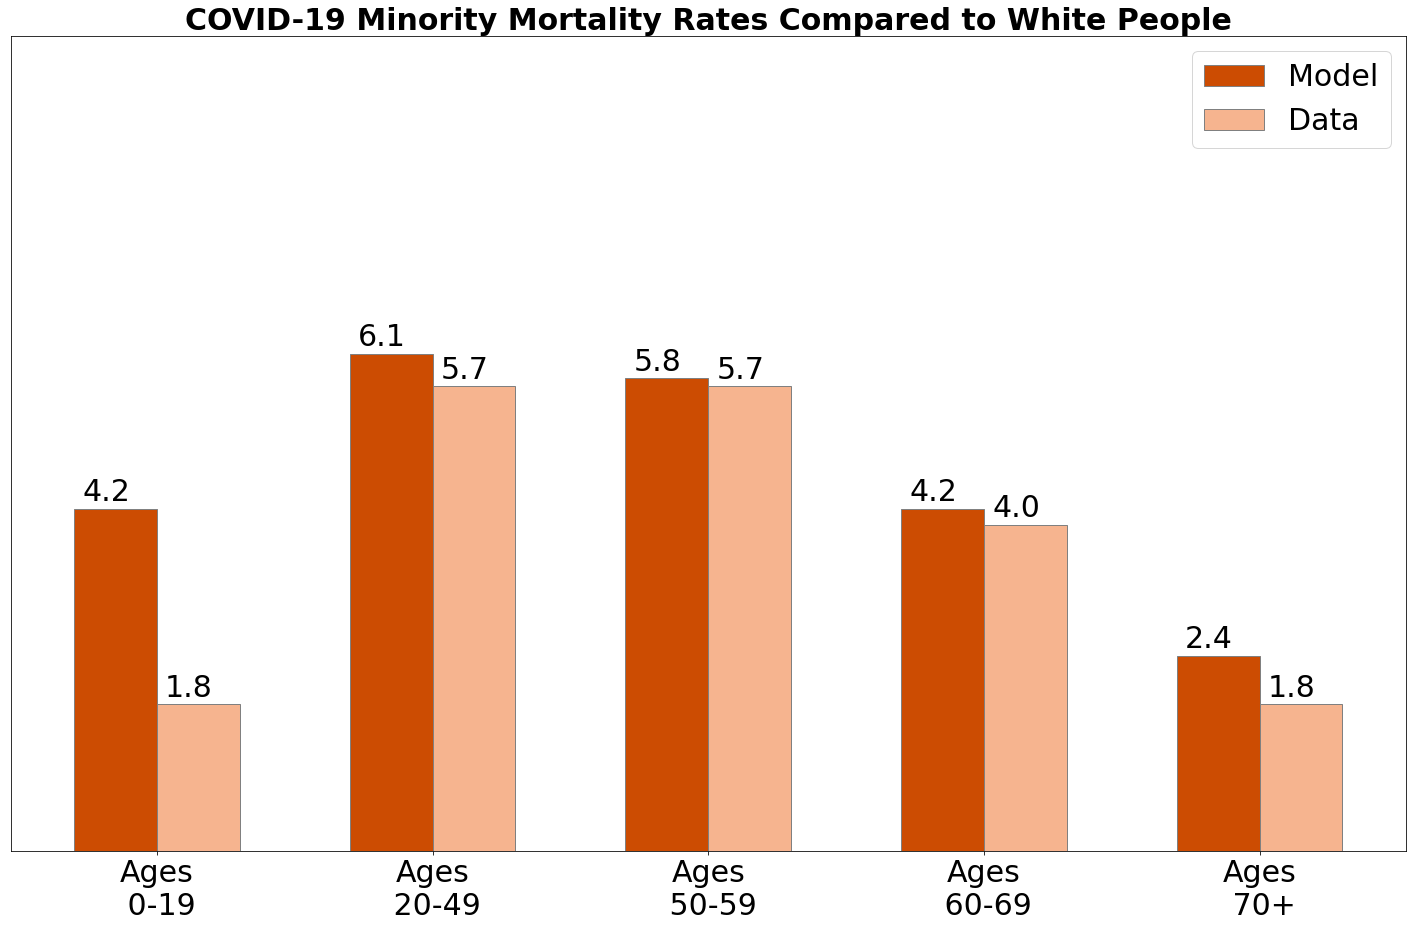

8495.573045310683


In [14]:
sd_params=res9.x
mult = np.concatenate((sd_params,sd_params))
contacts_total_new = mult*C
params_test = fitting_params.copy()
params_test[1] = contacts_total_new

#run model
[deaths, y0_2021] = run_model_sd_all_year(params_test,y0)
print(sum(deaths))
print(np.round(deaths[0:5]))
print(np.round(deaths[5:10]))
plotting_fun_comp(deaths,total_pops,np.zeros(10),all_mr_comp)


deaths_new = next_four_mo_no_intervention(params_test,y0_2021)
print(sum(deaths_new))

In [16]:
bounds = Bounds([0,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1])
s0 = 0.2*np.ones(10)
f = lambda sd: contact_multipliers_objfn_fit_age_race(sd,fitting_params,known_mr_comp, known_deaths_o,y0,total_pops)
res10 = scipy.optimize.minimize(f,s0,method='nelder-mead',bounds=bounds)
print(res10.x)

[3.31645098e-01 5.98746049e-01 4.49476319e-01 2.07810606e-01
 6.06352713e-01 4.77529612e-01 4.24020396e-01 2.93761324e-01
 3.01675505e-03 1.49239410e-07]


911.3078873523214
[  2.  12.  52. 188. 439.]
[ 4. 24. 55. 78. 58.]


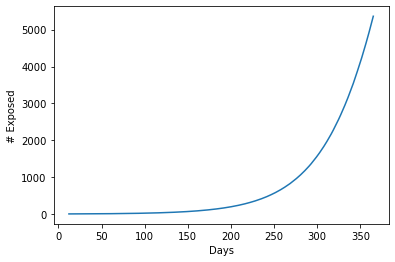

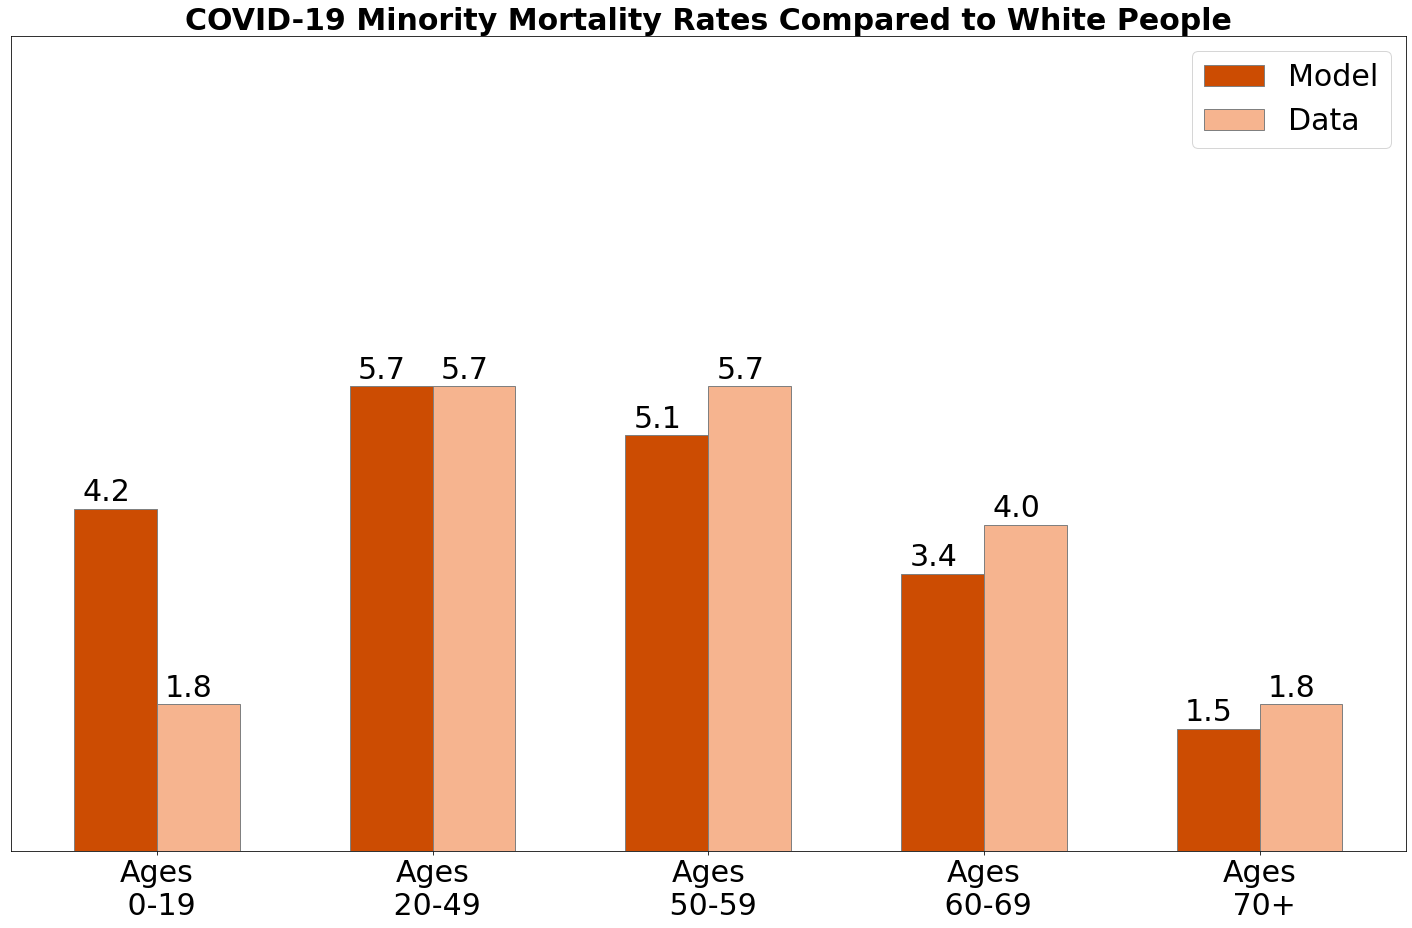

4652.584720786424


In [17]:
sd_params=res10.x
mult1 = np.concatenate((sd_params[0:5],sd_params[0:5]))
mult2 = np.concatenate((sd_params[5:],sd_params[5:]))
contacts_total_new = np.vstack((mult1*C[0:5,:],mult2*C[5:,:]))
params_test = fitting_params.copy()
params_test[1] = contacts_total_new

#run model
[deaths, y0_2021] = run_model_sd_all_year(params_test,y0)
print(sum(deaths))
print(np.round(deaths[0:5]))
print(np.round(deaths[5:10]))
plotting_fun_comp(deaths,total_pops,np.zeros(10),all_mr_comp)


deaths_new = next_four_mo_no_intervention(params_test,y0_2021)
print(sum(deaths_new))